In [1]:
using Pkg
Pkg.add(url="https://github.com/bergermann/Dragoon.jl.git")
Pkg.update()

    Updating git-repo `https://github.com/bergermann/Dragoon.jl.git`


   Resolving package versions...


  No Changes to `\\WINAD\benutzer$\bergermann\Desktop\Julia Files\JuXIMC.jl\Project.toml`
  No Changes to `\\WINAD\benutzer$\bergermann\Desktop\Julia Files\JuXIMC.jl\Manifest.toml`

    Updating registry at `C:\Users\bergermann\.julia\registries\General.toml`


    Updating git-repo `https://github.com/mppmu/BoostFractor.jl.git`


    Updating git-repo `https://github.com/bergermann/Dragoon.jl.git`


  No Changes to `\\WINAD\benutzer$\bergermann\Desktop\Julia Files\JuXIMC.jl\Project.toml`
  No Changes to `\\WINAD\benutzer$\bergermann\Desktop\Julia Files\JuXIMC.jl\Manifest.toml`


In [2]:
cd("\\\\inst3\\data\\Benutzer\\bergermann\\Desktop\\Julia Files\\JuXIMC.jl")

using Dragoon
using Dates
using Plots
using JLD2
using LaTeXStrings


include(joinpath(pwd(),"src/vna_control.jl"));
include(joinpath(pwd(),"src/JuXIMC.jl"));
include(joinpath(pwd(),"examplesdom/dragoonstuff.jl"));

include("stages2discs_c.jl");

In [3]:
vna = connectVNA();
# setupFromFile(vna,"src/vna_10G_50M.txt")

TCPSocket(Base.Libc.WindowsRawSocket(0x000000000000111c) active, 0 bytes waiting)

In [4]:
# setAveraging(vna,false)
# setFrequencies(vna,20.31e9,1.5e9)
setSweepPoints(vna,128)

24

In [7]:
freqs = collect(Float64,getFreqAsBinBlockTransfer(vna))

function objRefVNA(booster::Booster,freqs::Vector{Float64},(vna,ref0)::Tuple{TCPSocket,Vector{ComplexF64}})
    # sleep(1)

    ref = getTrace(vna)

    return sum(abs.(ref-ref0))
end

function objRefRef(booster::Booster,freqs::Vector{Float64},(ref,ref0)::Tuple{Vector{ComplexF64},Vector{ComplexF64}})
    return sum(abs.(ref-ref0))
end

ObjRefVNA(vna,ref0) = Callback(objRefVNA,(vna,ref0))
ObjRefRef(ref,ref0) = Callback(objRefRef,(ref,ref0));

In [8]:
infoXIMC();

D = requestDevices("Motor 7","Monica");


XIMC library version: 2.13.6


Device count: 3


 D | Name                             | Serial   | Port     | Stage           


 1 | xi-net://134.61.12.184/0000469F  | 18079    | Axis 1   | Big Chungus     
 2 | xi-net://134.61.12.184/000046A8  | 18088    | Axis 2   | Monica          
 3 | xi-net://134.61.12.184/00008303  | 33539    |          | Motor 7         


In [9]:
devices = Devices(D,stagecals,stagecols,stagezeros,stageborders,stagehomes);
b = PhysicalBooster(devices, τ=1e-3,ϵ=9.4,maxlength=0.2);

# homeHome(b)

PhysicalBooster(Devices(Int32[3, 2], ["Motor 7", "Monica"], [(:mm, 800.0), (:mm, -800.0)], [(:mm, -26.0), (:mm, 66.0)], [(:mm, -2.0, 4.0), (:mm, -4.0, 2.0)], [(:mm, 2.0, 27.0), (:mm, 14.0, 66.0)], [(:mm, 10.0), (:mm, 20.0)]), [0.012876123046875, 0.027947724609375002], 2, 0.001, 9.4, 0.2, DateTime("2023-09-08T14:36:06.588"), DateTime("2023-09-08T14:36:06.588"), 0.0)

In [ ]:
### scan

move(b,[0.013,0.027]; additive=false)

ref0 = getTrace(vna)
objF = ObjRefVNA(vna,ref0)
objFR(ref) = ObjRefRef(ref,ref0)

steps = 20

hist = initHist(b,(2*steps+1)^2+1,freqs,objFR(ref0));
updateHist!(b,hist,freqs,objFR(ref0))
R = zeros(ComplexF64,2*steps+1,2*steps+1,length(ref0))

p0 = copy(b.pos)

@time for i in -steps:steps, j in -steps:steps
    j == -steps && println("i: $i")

    move(b,p0+[i*0.0001,j*0.0001]; additive=false)
    
    ref = getTrace(vna)
    updateHist!(b,hist,freqs,objFR(ref))
    R[i+steps+1,j+steps+1,:] = ref
end

# @save "2_discs_c_scan_20p3G_peak.jld2" ref0 hist R freqs

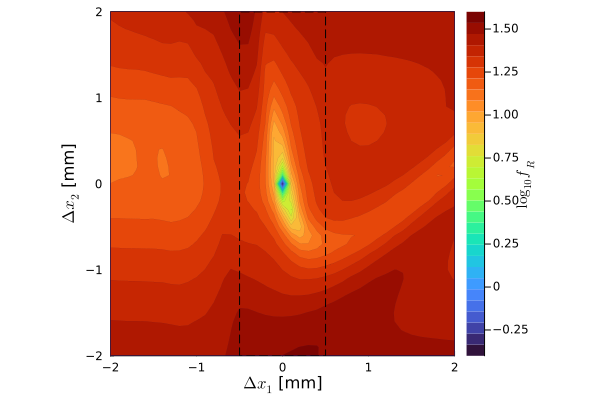

(-0.3184001895497263, 1.5400265513349594)


In [10]:
@load "2_discs_c_scan_20p3G_peak.jld2"

n = 20
l = 2

R_ = reshape((x->x.objvalue).(hist[1:end-1]),(2n+1,2n+1)); println(log10.(extrema(R_)))


scan = contourf(-l:l/n:l,-l:l/n:l,log10.(R_); color=:turbo,levels=30,lw=0,aspect_ratio=:equal,clim=(-0.4,1.6),colorbar_title=L"\log_{10} f_R")
# plot!([-6,-6,2.5,2.5,-6],[-2.5,4,4,-2.5,-2.5]; c=:black,linestyle=:dash,legend=false)
plot!([-0.5,-0.5,0.5,0.5,-0.5],[-2,2,2,-2,-2]; c=:black,linestyle=:dash,legend=false)
xlims!((-l,l))
ylims!((-l,l))
xlabel!(L"\Delta x_1"*" [mm]")
ylabel!(L"\Delta x_2"*" [mm]")
display(scan)
# savefig("2disc_c_scan_20p3G_peak.pdf")

In [11]:
p0 = [0.013,0.027]
move(b,p0; additive=false); getTrace(vna);

In [13]:
### optimization linesearch

move(b,p0; additive=false)

ref0 = getTrace(vna)
objF = ObjRefVNA(vna,ref0)
objFR(ref) = ObjRefRef(ref,ref0)

histls = initHist(b,10001,freqs,objFR(ref0));
updateHist!(b,histls,freqs,objFR(ref0))

move(b,[0.0,0.001]; additive=true)

tracels = linesearch(b,histls,freqs,1e-6,
    objF,
    SolverSteep,
    Derivator1(1e-5,"double"),
    StepNorm("unit"),
    SearchExtendedSteps(50),
    UnstuckRandom(1e-5,1);
    ϵgrad=0.,maxiter=Int(1e2),showtrace=true,
    resettimer=true);


    
# tracels = linesearch(b,histls,freqs,5e-6,
#     objF,
#     SolverNewton("inv"),
#     Derivator2(5e-5,5e-5,"double"),
#     StepNorm("unit"),
#     SearchStandard(0,50),
#     UnstuckRandom(1e-4,1);
#     ϵgrad=0.,maxiter=Int(10),showtrace=true,
#     resettimer=true);


In [ ]:
idx = findfirst(x->x.objvalue==0.,hist)
if isnothing(idx); idx= length(hist); end
idx -= 1

x_ = cat((x->x.pos).(reverse(hist[1:idx-1]))...; dims=2)
X = cat((x->x.x).(trace)...; dims=2)

In [ ]:
plot!(scan,(X[1,:].-p0[1])/1e-3,(X[2,:].-p0[2])/1e-3; c=:black)

In [ ]:
plot!(scan,(x_[1,:].-p0[1])/1e-3,(x_[2,:].-p0[2])/1e-3; c=:black)

In [ ]:
b.pos - p0

In [ ]:
analyse(histls,tracels,freqs)

In [1]:
### optimization simulated annealing

p0 = [0.013,0.027]

move(b,p0; additive=false)

ref0 = getTrace(vna)
objF = ObjRefVNA(vna,ref0)
objFR(ref) = ObjRefRef(ref,ref0)

hist = initHist(b,10001,freqs,objFR(ref0));
updateHist!(b,hist,freqs,objFR(ref0))

move(b,[0.0,0.001]; additive=true)

trace = simulatedAnnealing(b,hist,freqs,T,100e-6,
    objF,
    UnstuckDont;
    maxiter=Int(100),
    showtrace=true,
    showevery=100,
    unstuckisiter=true,
    traceevery=1,
    resettimer=true);

UndefVarError: UndefVarError: `move` not defined